In [2]:
import torch
from torch.utils.data import Dataset,random_split
import numpy as np
import os

class NPZDataset(Dataset):
    def __init__(self, root_dir, phase="train", transform=None):

        self.root_dir = os.path.join(root_dir, phase)
        self.transform = transform
        self.classes = {"no": 0, "sphere": 1, "vort": 2}
        self.file_paths = []
        self.labels = []
        for class_name, label in self.classes.items():
            class_dir = os.path.join(self.root_dir, class_name)
            if os.path.exists(class_dir):
                for file in os.listdir(class_dir):
                    if file.endswith(".npy"):
                        self.file_paths.append(os.path.join(class_dir, file))
                        self.labels.append(label)

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        label = self.labels[idx]
        data = np.load(file_path)
        data = torch.tensor(data, dtype=torch.float32)
        if self.transform:
            data = self.transform(data)
        
        return data, label


In [40]:
from torch.utils.data import DataLoader

dataset_path = "/kaggle/input/dataset/dataset"

train_dataset0 = NPZDataset(root_dir=dataset_path, phase="train")
train_ratio = 0.9
val_ratio = 1 - train_ratio  
total_size = len(train_dataset0)
train_size = int(total_size * train_ratio)
val_size = total_size - train_size  
train_dataset, val_dataset = random_split(train_dataset0, [train_size, val_size])
test_dataset = NPZDataset(root_dir=dataset_path, phase="val")
print(f"size of train_dataset:{len(train_dataset)}")
print(f"size of val_dataset:{len(val_dataset)}")
print(f"size of test_dataset:{len(test_dataset)}")

size of train_dataset:27000
size of val_dataset:3000
size of test_dataset:7500


In [5]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

for batch in train_loader:
    images, labels = batch
    print("Train Batch:", images.shape, labels.shape)
    break  

for batch in val_loader:
    images, labels = batch
    print("Validation Batch:", images.shape, labels.shape)
    break  

Train Batch: torch.Size([32, 1, 150, 150]) torch.Size([32])
Validation Batch: torch.Size([32, 1, 150, 150]) torch.Size([32])


In [34]:
import matplotlib.pyplot as plt
import torch

def visualize_class_samples(train_loader, class_names, num_samples=5):

    class_images = {cls: [] for cls in range(len(class_names))} 
    for images, labels in train_loader:
        for img, label in zip(images, labels):
            label = label.item()
            if len(class_images[label]) < num_samples:
                class_images[label].append(img)
        if all(len(v) == num_samples for v in class_images.values()):
            break

    # Plot the images
    fig, axes = plt.subplots(len(class_names), num_samples, figsize=(num_samples * 2, len(class_names) * 2))

    for cls, imgs in class_images.items():
        for i, img in enumerate(imgs):
            ax = axes[cls, i] if len(class_names) > 1 else axes[i] 
            img = img.numpy().transpose(1, 2, 0) 
            ax.imshow(img, cmap="gray") 
            ax.axis("off")
            if i == 0:
                ax.set_ylabel(class_names[cls], fontsize=12, rotation=90, labelpad=10)

    plt.tight_layout()
    plt.show()


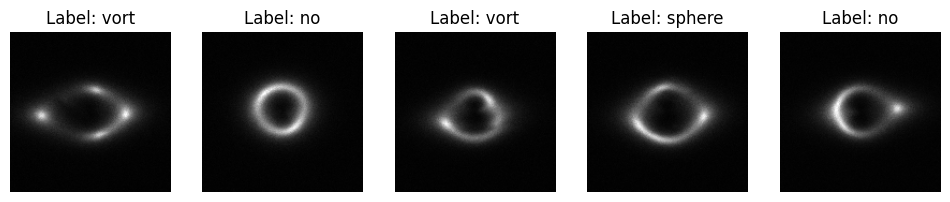

In [35]:
visualize_samples(train_loader,class_names=["no","sphere","vort"])


In [6]:
from tqdm import tqdm

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from torch.utils.data import DataLoader
from sklearn.preprocessing import label_binarize

def train_model(model, train_loader, val_loader, device, epochs=10, lr=0.001, step_size=5, gamma=0.5):

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        model.train()
        train_loss, correct, total = 0, 0, 0
        for data, targets in tqdm(train_loader):
            data, targets = data.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == targets).sum().item()
            total += targets.size(0)

        train_loss /= len(train_loader)
        train_acc = correct / total
        train_losses.append(train_loss)

        # Validation Phase
        model.eval()
        val_loss, correct, total = 0, 0, 0
        all_preds, all_labels = [], []
        
        with torch.no_grad():
            for data, targets in val_loader:
                data, targets = data.to(device), targets.to(device)
                outputs = model(data)
                loss = criterion(outputs, targets)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == targets).sum().item()
                total += targets.size(0)

                all_preds.append(outputs.cpu().numpy())
                all_labels.append(targets.cpu().numpy())

        val_loss /= len(val_loader)
        val_acc = correct / total
        val_losses.append(val_loss)

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        scheduler.step()

        # Plot ROC Curve
        all_preds = np.concatenate(all_preds)
        all_labels = np.concatenate(all_labels)
        all_labels = label_binarize(all_labels, classes=[0, 1, 2])
        fpr, tpr, roc_auc = {}, {}, {}

        plt.figure(figsize=(7, 5))
        for i in range(3):  
            fpr[i], tpr[i], _ = roc_curve(all_labels[:, i], all_preds[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
            plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

        plt.plot([0, 1], [0, 1], 'k--') 
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - Epoch {epoch+1}')
        plt.legend(loc="lower right")
        plt.show()


In [8]:
import timm
model=timm.create_model("resnet18",pretrained=True,num_classes=3)

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

In [9]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

In [10]:
import torch.nn as nn
model.conv1=nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
device="cuda"

In [11]:
model.to(device)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m


Epoch 1/10


100%|██████████| 844/844 [03:23<00:00,  4.14it/s]


Train Loss: 1.1000, Train Acc: 0.3377
Val Loss: 1.0985, Val Acc: 0.3343


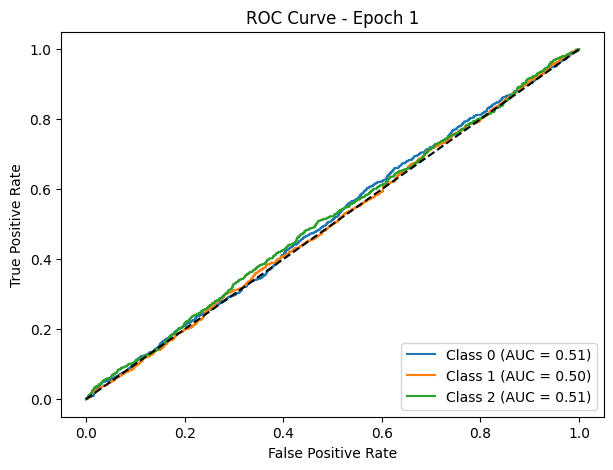


Epoch 2/10


100%|██████████| 844/844 [01:03<00:00, 13.31it/s]


Train Loss: 1.0692, Train Acc: 0.3884
Val Loss: 1.0466, Val Acc: 0.4453


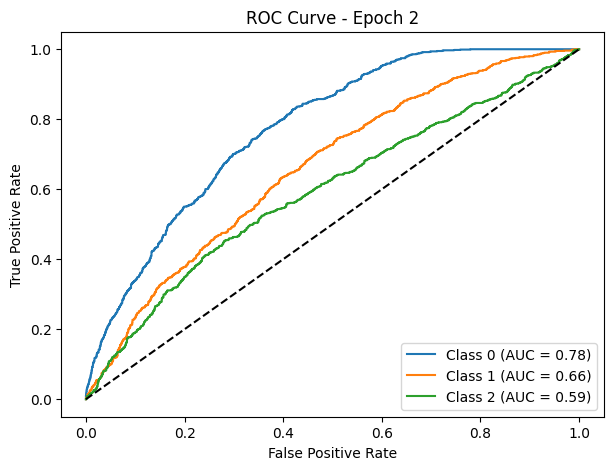


Epoch 3/10


100%|██████████| 844/844 [01:04<00:00, 13.04it/s]


Train Loss: 0.8213, Train Acc: 0.6046
Val Loss: 0.7701, Val Acc: 0.6330


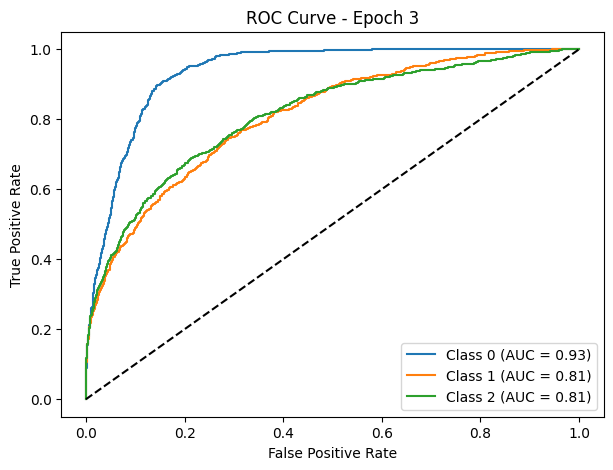


Epoch 4/10


100%|██████████| 844/844 [01:03<00:00, 13.21it/s]


Train Loss: 0.5722, Train Acc: 0.7576
Val Loss: 0.5693, Val Acc: 0.7520


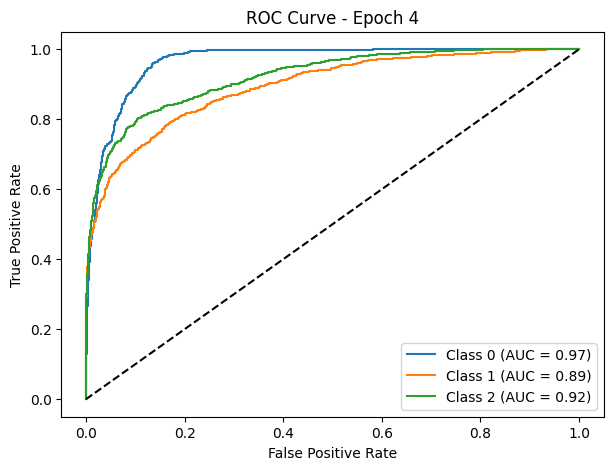


Epoch 5/10


100%|██████████| 844/844 [01:03<00:00, 13.26it/s]


Train Loss: 0.4103, Train Acc: 0.8357
Val Loss: 0.3821, Val Acc: 0.8473


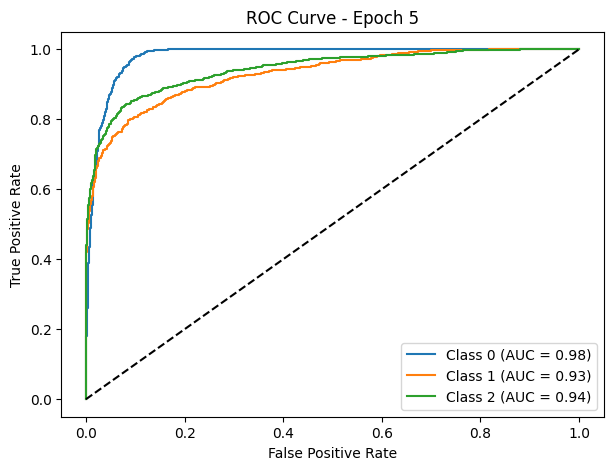


Epoch 6/10


100%|██████████| 844/844 [01:02<00:00, 13.41it/s]


Train Loss: 0.2826, Train Acc: 0.8917
Val Loss: 0.3232, Val Acc: 0.8793


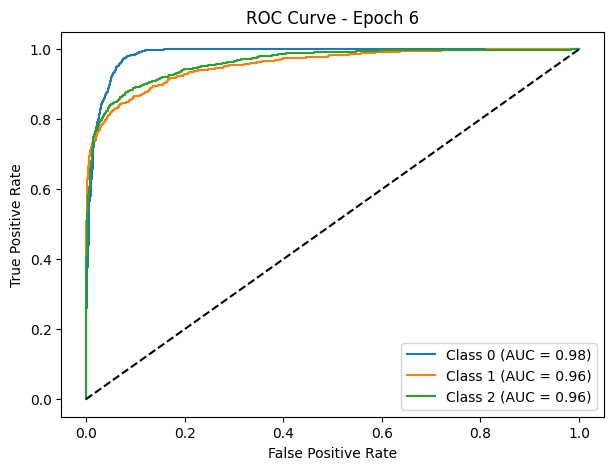


Epoch 7/10


100%|██████████| 844/844 [01:02<00:00, 13.49it/s]


Train Loss: 0.2370, Train Acc: 0.9117
Val Loss: 0.2593, Val Acc: 0.8993


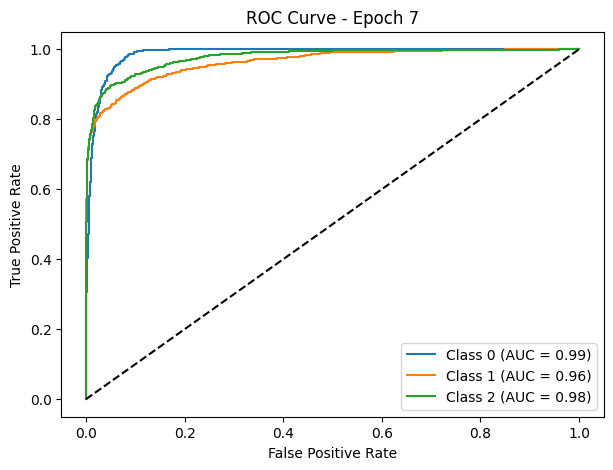


Epoch 8/10


100%|██████████| 844/844 [01:02<00:00, 13.42it/s]


Train Loss: 0.2029, Train Acc: 0.9243
Val Loss: 0.2577, Val Acc: 0.9007


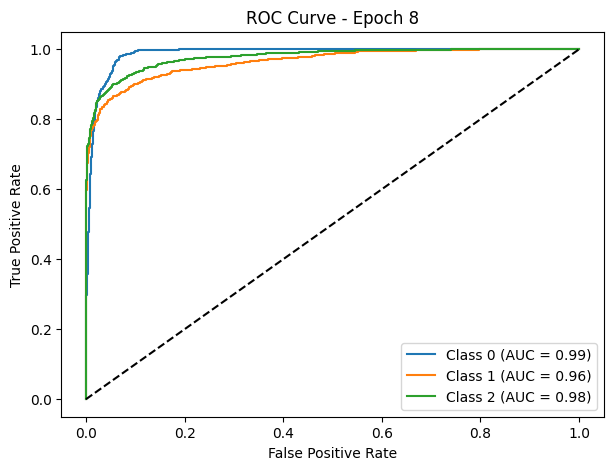


Epoch 9/10


100%|██████████| 844/844 [01:02<00:00, 13.44it/s]


Train Loss: 0.1739, Train Acc: 0.9360
Val Loss: 0.2505, Val Acc: 0.9097


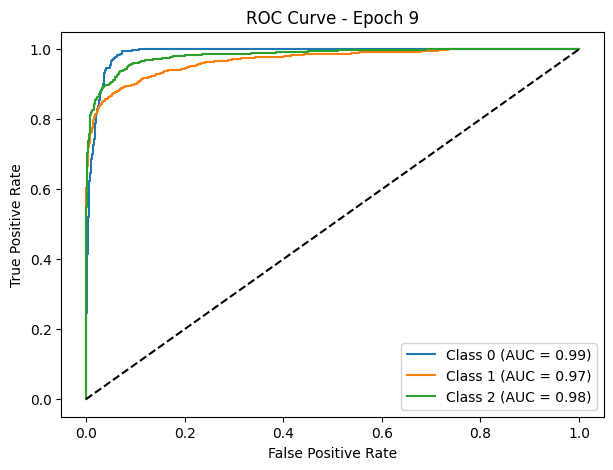


Epoch 10/10


100%|██████████| 844/844 [01:03<00:00, 13.36it/s]


Train Loss: 0.1493, Train Acc: 0.9449
Val Loss: 0.3041, Val Acc: 0.8903


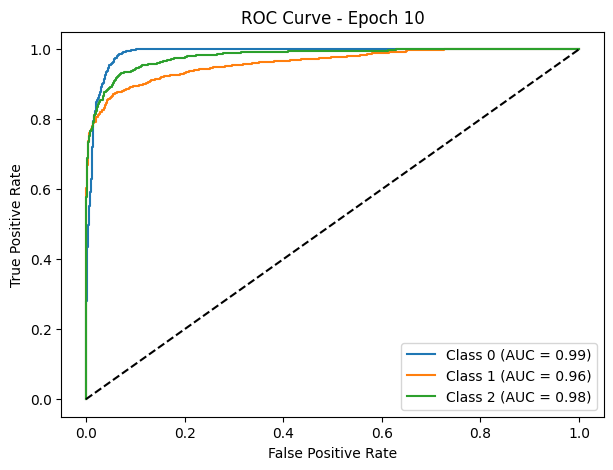

In [12]:
train_model(model,train_loader,val_loader,device)

In [36]:
import os
import torch
def save_model(model, save_dir="saved_models", filename="model.pth"):
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, filename)
    torch.save(model.state_dict(), save_path)
    print(f"Model saved at: {save_path}")
save_model(model)


Model saved at: saved_models/model.pth


In [37]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.preprocessing import label_binarize

def evaluate_model(model, test_loader, device, class_names):

    model.to(device)
    model.eval()  

    all_preds, all_labels = [], []

    with torch.no_grad():
        for data, targets in tqdm(test_loader, desc="Evaluating", unit="batch"):
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            all_preds.append(probs.cpu().numpy())
            all_labels.append(targets.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    all_labels_bin = label_binarize(all_labels, classes=np.arange(len(class_names)))
    fpr, tpr, roc_auc = {}, {}, {}

    plt.figure(figsize=(8, 6))
    for i in range(len(class_names)):  
        fpr[i], tpr[i], _ = roc_curve(all_labels_bin[:, i], all_preds[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

    # Print AUC scores
    print("\nAUC Scores:")
    for i, cls in enumerate(class_names):
        print(f"  {cls}: {roc_auc[i]:.4f}")

    # Plot ROC curve
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.savefig('ROC_curve.png')
    plt.show()

    # plot confusion matrix
    y_pred = np.argmax(all_preds, axis=1)  
    cm = confusion_matrix(all_labels, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.savefig('confusion_Marix.png')
    plt.title("Confusion Matrix")
    plt.show()


Evaluating: 100%|██████████| 235/235 [00:13<00:00, 17.39batch/s]



AUC Scores:
  no: 0.9874
  sphere: 0.9559
  vort: 0.9862


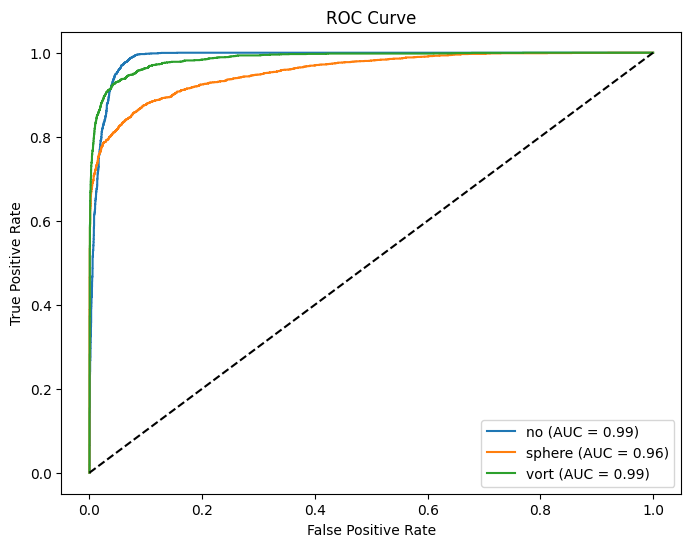

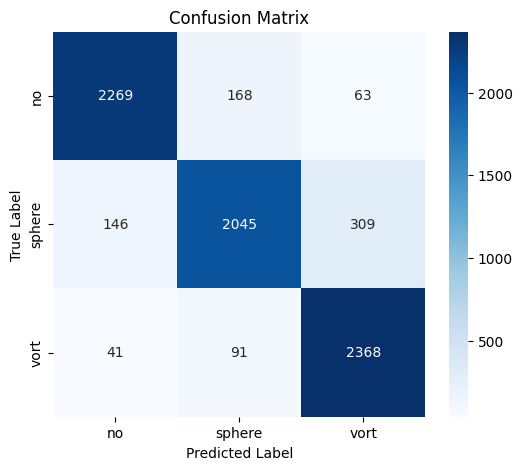

In [38]:
evaluate_model(model,test_loader,device,class_names=["no", "sphere", "vort"])